In [26]:
import torch
import torchvision
from torch import optim
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [27]:
# Load CIFAR-10 data

train_set = datasets.CIFAR10('cifar',
            train=True, download=True,
            transform=transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor()
            ]))
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)


test_set = datasets.CIFAR10('cifar', train=False,
                          transform = transforms.Compose([
                              transforms.Resize((32, 32)),
                              transforms.ToTensor()
                          ]))
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

Files already downloaded and verified


In [28]:
# Сheck the shape of the input data

print(f"Shape of train data: {train_loader.dataset.data.shape}")
print(f"Shape of test data: {test_loader.dataset.data.shape}")

Shape of train data: (50000, 32, 32, 3)
Shape of test data: (10000, 32, 32, 3)


In [29]:
# Function for data visialization

def visualize(dataset):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    images = images.numpy()
    fig = plt.figure(figsize=(10, 10))
    for idx in np.arange(10):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1,2,0)))
        ax.set_title(train_set.classes[labels[idx]])

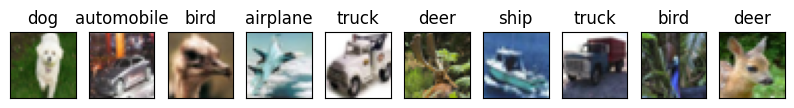

In [30]:
# Visualize some examples of input data from train

visualize(train_loader)

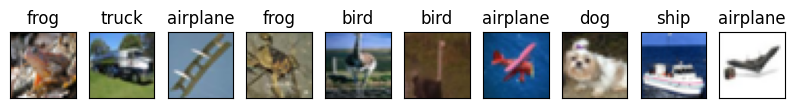

In [31]:
# Visualize some examples of input data from test

visualize(test_loader)

In [32]:
# ResNet34 architecture

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet34(nn.Module):
    def __init__(self, block=BasicBlock, num_blocks=[3, 4, 6, 3], num_classes=10):
        super(ResNet34, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [33]:
# Make a directory to save the model checkpoint

MODEL_PATH = "cifar10/"
MODEL_EXP_PATH = MODEL_PATH + "resnet34/"
try:
    os.mkdir(MODEL_PATH)
except:
    print("Folder already exists")

try:
    os.mkdir(MODEL_EXP_PATH)
except:
    print("Folder already exists")

Folder already exists
Folder already exists


In [34]:
def train(model, train_loader, criterion, optimizer, num_epochs, device, filename):
    model.to(device)
    loss_list = []
    accuracy_list = []
    best_accuracy = 0.0
    best_train_loss = 100
    all_predictions = 0
    correct_predictions = 0
    print('Training started.')
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs) 
            loss = criterion(outputs, labels) 
            loss.backward()  
            optimizer.step()
            
            running_loss += loss.item()

            _, predictions = torch.max(outputs.data, dim=1)
            all_predictions += labels.size(0)
            correct_predictions += (predictions == labels).sum().item()       
        
        epoch_loss = running_loss / len(train_loader)
        loss_list.append(epoch_loss)
        
        epoch_accuracy = correct_predictions / all_predictions
        accuracy_list.append(epoch_accuracy)
        
        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            np.save(filename + 'best_accuracy.npy', np.array([epoch_accuracy]))
            torch.save(model.state_dict(), filename + "/baseline_model_accuracy")

        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            np.save(filename + 'best_train_loss.npy', np.array([epoch_loss]))
            torch.save(model.state_dict(), filename + "/baseline_model_loss")
       
        end_time = time.time()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f},  Epoch time: {(end_time - start_time):.4f} sec')
    
    print('Training is completed.')

    return loss_list, accuracy_list

In [38]:
def test(model, test_loader, criterion, device):
    model.eval()  
    test_loss = 0.0
    all_predictions = 0
    correct_predictions = 0
    
    with torch.no_grad():  
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predictions = torch.max(outputs.data, dim=1)
            all_predictions += labels.size(0)
            correct_predictions += (predictions == labels).sum().item()   
    test_loss = test_loss / len(test_loader)
    test_accuracy = correct_predictions / all_predictions

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

In [36]:
# Train model 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ResNet34()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
loss_list, accuracy_list = train(model, train_loader, criterion, optimizer, 100, device, MODEL_EXP_PATH)

cuda
Training started.
Epoch [1/100], Loss: 1.4481, Accuracy: 0.4735,  Epoch time: 36.8836 sec
Epoch [2/100], Loss: 0.8785, Accuracy: 0.5824,  Epoch time: 36.8080 sec
Epoch [3/100], Loss: 0.6382, Accuracy: 0.6474,  Epoch time: 36.9270 sec
Epoch [4/100], Loss: 0.4988, Accuracy: 0.6924,  Epoch time: 37.0175 sec
Epoch [5/100], Loss: 0.3974, Accuracy: 0.7266,  Epoch time: 36.7994 sec
Epoch [6/100], Loss: 0.3246, Accuracy: 0.7531,  Epoch time: 36.8344 sec
Epoch [7/100], Loss: 0.2605, Accuracy: 0.7754,  Epoch time: 36.7757 sec
Epoch [8/100], Loss: 0.2138, Accuracy: 0.7940,  Epoch time: 36.8154 sec
Epoch [9/100], Loss: 0.1701, Accuracy: 0.8102,  Epoch time: 36.7922 sec
Epoch [10/100], Loss: 0.1402, Accuracy: 0.8242,  Epoch time: 36.8566 sec
Epoch [11/100], Loss: 0.1181, Accuracy: 0.8363,  Epoch time: 36.7941 sec
Epoch [12/100], Loss: 0.0925, Accuracy: 0.8473,  Epoch time: 36.8090 sec
Epoch [13/100], Loss: 0.0841, Accuracy: 0.8569,  Epoch time: 36.9173 sec
Epoch [14/100], Loss: 0.0747, Accurac

In [42]:
# Load model with best train loss

model.load_state_dict(torch.load(MODEL_EXP_PATH + 'baseline_model_loss'))

<All keys matched successfully>

In [43]:
# Test model 

test(model, test_loader, criterion, device)

Test Loss: 0.6349, Test Accuracy: 0.8426


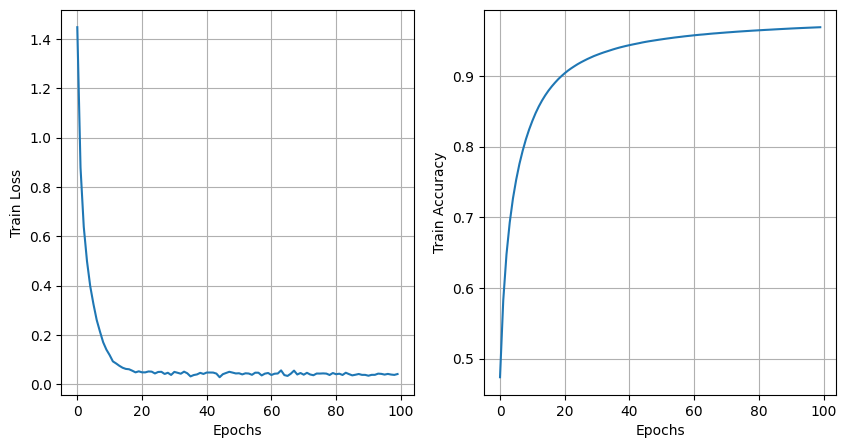

In [49]:
# Plot graphics for train loss and accuracy per epoch

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(loss_list)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Train Loss')
ax[0].grid(True)
ax[1].plot(accuracy_list)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Train Accuracy')
ax[1].grid(True)
plt.show()